In [1]:
-- Requirements
require 'nn'
require 'image'
require 'csvigo'
require 'loadcaffe'
require 'optim'
Plot = require 'itorch.Plot'

In [2]:
-- loading data
file = csvigo.load({path = "/home/lerrel/Dhiraj_stuff/Kaggle/Right_Whale/data/train.csv",mode = "large"})

-- reading images from folder
folder_path = "/home/lerrel/Dhiraj_stuff/Kaggle/Right_Whale/data/imgs"
data = image.loadJPG(folder_path.."/"..file[2][1],3,'byte')

-- num of train data
--num_train_data = #file - 1
num_train_data = 50

-- we will be using X_test_scaled for VGG-NET .. as it requires input to be of 224 X 224
X_train = torch.ByteTensor(num_train_data , data:size()[1], 224, 224 ):zero()

--in the file .. whale id are given.. we have to define the class depending on that
y_train = torch.Tensor(num_train_data ):zero()
-- it contains id corresponding to the class
whale_id = {}

-- insert the first data
X_train[1] = image.scale( data, 224, 224)
table.insert(whale_id, file[2][2])
y_train[1] = 1

for i = 2, num_train_data do
    
    -- for x
    data = image.loadJPG(folder_path.."/"..file[i+1][1],3,'byte')
    X_train[i] = image.scale(data, 224,224)
    
    -- for y label
    j = 1
    while j <= #whale_id do
        
        if whale_id[j] == file[ i + 1 ][2] then
            break
        end
        
        j = j + 1 
    end
    
    if j == #whale_id + 1 then
        table.insert(whale_id, file[ i + 1 ][2])
    end
    
    y_train[i] = j 
    
end

<csv>	parsing file: /home/lerrel/Dhiraj_stuff/Kaggle/Right_Whale/train.csv	


<csv>	parsing done	


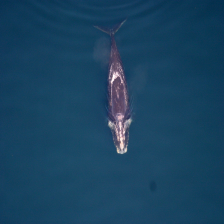

In [3]:
itorch.image(X_train[1])

In [4]:
#whale_id

88	


In [5]:
-- loading the model 
-- i'm going to use pretrained model.. with little change in the architecture
model_VGG = loadcaffe.load(' VGG_ILSVRC_19_layers_deploy.prototxt','VGG_ILSVRC_19_layers.caffemodel','nn')

Successfully loaded VGG_ILSVRC_19_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3


conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv3_4: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv4_4: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


conv5_4: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


In [6]:
print(tostring(model_VGG))

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> (25) -> (26) -> (27) -> (28) -> (29) -> (30) -> (31) -> (32) -> (33) -> (34) -> (35) -> (36) -> (37) -> (38) -> (39) -> (40) -> (41) -> (42) -> (43) -> (44) -> (45) -> (46) -> output]
  (1): nn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1)
  (2): nn.ReLU
  (3): nn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1)
  (4): nn.ReLU
  (5): nn.SpatialMaxPooling(2,2,2,2)
  (6): nn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)
  (7): nn.ReLU
  (8): nn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)
  (9): nn.ReLU
  (10): nn.SpatialMaxPooling(2,2,2,2)
  (11): nn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)
  (12): nn.ReLU
  (13): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (14): nn.ReLU
  (15): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (16): nn.ReLU
  (17): nn.SpatialConvolution(256

In [7]:
-- we will try to fine tune the FC layers... so i will delete layers from 39 - 46 from model_VGG
model_VGG:remove(46)
model_VGG:remove(45)
model_VGG:remove(44)
model_VGG:remove(43)
model_VGG:remove(42)
model_VGG:remove(41)
model_VGG:remove(40)
model_VGG:remove(39)
print(tostring(model_VGG))

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> (25) -> (26) -> (27) -> (28) -> (29) -> (30) -> (31) -> (32) -> (33) -> (34) -> (35) -> (36) -> (37) -> (38) -> output]
  (1): nn.SpatialConvolution(3 -> 64, 3x3, 1,1, 1,1)
  (2): nn.ReLU
  (3): nn.SpatialConvolution(64 -> 64, 3x3, 1,1, 1,1)
  (4): nn.ReLU
  (5): nn.SpatialMaxPooling(2,2,2,2)
  (6): nn.SpatialConvolution(64 -> 128, 3x3, 1,1, 1,1)
  (7): nn.ReLU
  (8): nn.SpatialConvolution(128 -> 128, 3x3, 1,1, 1,1)
  (9): nn.ReLU
  (10): nn.SpatialMaxPooling(2,2,2,2)
  (11): nn.SpatialConvolution(128 -> 256, 3x3, 1,1, 1,1)
  (12): nn.ReLU
  (13): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (14): nn.ReLU
  (15): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (16): nn.ReLU
  (17): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (18): nn.ReLU
  (19): nn.SpatialMaxPoo

In [8]:
-- for our case the number of labels to predict are 448.. so for this Im going to change final FC layer of orginal VGG_Net
model = nn.Sequential()

-- also reduced 4096 to 1024
model:add(nn.Linear(25088,1024))
model:add(nn.ReLU())
model:add(nn.Dropout(0.5))

-- removing this part.. my cpu is unable to handle it
--model:add(nn.Linear(4096,4096))
--model:add(nn.ReLU())
--model:add(nn.Dropout(0.5))

model:add(nn.Linear(1024,448))
model:add(nn.LogSoftMax())

print(tostring(model))

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> output]
  (1): nn.Linear(25088 -> 1024)
  (2): nn.ReLU
  (3): nn.Dropout(0.500000)
  (4): nn.Linear(1024 -> 448)
  (5): nn.LogSoftMax
}	


In [9]:
-- assign variables to w and to its gradient
w, dw = model:getParameters()

In [10]:
#w

 26150336
[torch.LongStorage of size 1]



In [11]:
-- chose the cost function
criterion = nn.ClassNLLCriterion()

In [12]:
find_accuracy = function(pred,expected)
    acc = pred:double():eq(expected:double()):sum() / (#pred)[1] 
    return acc 
end

In [13]:
-- f_eval function
-- NOTE - Add Desciption
-- also get to learn how to define function in torch
feval = function(w_new)
    
    if w ~= w_new then
        w:copy(w_new)
    end
    
    -- batch data implementation
    batch_size = 5
    
    -- to shuffle the data after every epoch
    start_idx = (start_idx or 0) + 1 
    if start_idx > (#X_train)[1] then 
        start_idx = 1
        epoch = (epoch or 0) + 1
        local shuffle = torch.randperm(num_train_data):long()
        X_train = X_train:index(1,shuffle)
        y_train = y_train:index(1,shuffle)
    end
    
    stop_idx  = start_idx + batch_size - 1
    if stop_idx > (#X_train)[1] then 
        stop_idx = (#X_train)[1]
        epoch = (epoch or 0) + 1
        local shuffle = torch.randperm(num_train_data):long()
        X_train = X_train:index(1,shuffle)
        y_train = y_train:index(1,shuffle)
    end
    
    -- copy the inputs in local variable
    local input = torch.Tensor(stop_idx - start_idx + 1, (#X_train)[2],(#X_train)[3],(#X_train)[4])
    local y = torch.Tensor(stop_idx - start_idx + 1)
    
    input[{{1, stop_idx - start_idx + 1},{}}] = X_train[{{start_idx,stop_idx},{}}]
    y[{{1, stop_idx - start_idx + 1}}] = y_train[{{start_idx, stop_idx}}]
    
    -- make the gradient zero.. to  avoid the accumulation
    dw:zero()
    
    -- calculating input for new model
    local model_input = model_VGG:forward(input)
    
    -- calculate the loss
    local batch_pred = model:forward(model_input)
    local batch_loss = criterion:forward(batch_pred,y)
    local grad_criterion = criterion:backward(batch_pred, y)
    model:backward(model_input, grad_criterion)
    
    -- finding the accuracy
    -- NOTE the batch pred dimension... max in row or column will be decided based on that
    local _,pred_indx = torch.max(batch_pred,2) 
    pred_indx:double()
    --local accuracy = pred_indx:double():eq(y):sum() / (stop_idx - start_idx + 1)
    local accuracy = find_accuracy(pred_indx,y)
    
    if verbose == true then
        print(string.format("Epoch = %d  Loss = %04f  Accuracy = %02f",epoch,batch_loss,accuracy))
    end
    
    
    -- assign value to start index
    start_idx = stop_idx 
    
    -- always return loss,gradient
    return batch_loss, dw
end


In [14]:
-- define optimization params
sgd_params = { learningRate = 1e-4,
   learningRateDecay = 0,
   weightDecay = 1,
   momentum = 0
}

In [15]:
-- the main loop
-- describe the stopping criterion
-- here i chose no of iteration
loss_h = {}
epoch = 0
num_epoch = 1
verbose = true
while epoch < num_epoch do 
    _,loss = optim.sgd(feval,w,sgd_params)
    table.insert(loss_h,loss[1])
end

Epoch = 0  Loss = 6.983176  Accuracy = 0.000000	


Epoch = 0  Loss = 8.172744  Accuracy = 0.000000	


Epoch = 0  Loss = 8.661345  Accuracy = 0.000000	


Epoch = 0  Loss = 8.491886  Accuracy = 0.000000	


Epoch = 0  Loss = 7.509132  Accuracy = 0.000000	


Epoch = 0  Loss = 7.834977  Accuracy = 0.000000	


Epoch = 0  Loss = 7.364815  Accuracy = 0.000000	


Epoch = 0  Loss = 8.450854  Accuracy = 0.000000	


Epoch = 0  Loss = 6.914019  Accuracy = 0.000000	


Epoch = 0  Loss = 7.677096  Accuracy = 0.000000	


Epoch = 0  Loss = 7.807629  Accuracy = 0.000000	


Epoch = 0  Loss = 7.817802  Accuracy = 0.000000	


Epoch = 0  Loss = 6.097440  Accuracy = 0.000000	


Epoch = 0  Loss = 6.753028  Accuracy = 0.000000	


Epoch = 0  Loss = 6.904688  Accuracy = 0.000000	


Epoch = 0  Loss = 5.777126  Accuracy = 0.000000	


Epoch = 0  Loss = 7.292645  Accuracy = 0.000000	


Epoch = 0  Loss = 7.326262  Accuracy = 0.000000	


Epoch = 0  Loss = 7.152694  Accuracy = 0.000000	


Epoch = 0  Loss = 6.794219  Accuracy = 0.000000	


Epoch = 1  Loss = 5.427362  Accuracy = 0.200000	


Epoch = 1  Loss = 5.803277  Accuracy = 0.000000	


Epoch = 1  Loss = 6.403575  Accuracy = 0.000000	


Epoch = 1  Loss = 5.426572  Accuracy = 0.000000	


Epoch = 1  Loss = 6.345944  Accuracy = 0.000000	


Epoch = 1  Loss = 4.501710  Accuracy = 0.000000	


Epoch = 1  Loss = 5.019055  Accuracy = 0.000000	


Epoch = 1  Loss = 4.314754  Accuracy = 0.200000	


Epoch = 1  Loss = 5.149056  Accuracy = 0.000000	


Epoch = 1  Loss = 5.493701  Accuracy = 0.200000	


Epoch = 1  Loss = 5.446295  Accuracy = 0.000000	


Epoch = 1  Loss = 4.999100  Accuracy = 0.000000	


Epoch = 1  Loss = 5.479128  Accuracy = 0.200000	


Epoch = 1  Loss = 5.377573  Accuracy = 0.000000	


Epoch = 1  Loss = 6.300273  Accuracy = 0.000000	


Epoch = 1  Loss = 5.294599  Accuracy = 0.200000	


Epoch = 1  Loss = 5.644864  Accuracy = 0.000000	


Epoch = 1  Loss = 5.269281  Accuracy = 0.000000	


Epoch = 1  Loss = 5.357380  Accuracy = 0.200000	


Epoch = 1  Loss = 5.474255  Accuracy = 0.200000	


Epoch = 2  Loss = 4.796582  Accuracy = 0.000000	


Epoch = 2  Loss = 4.527548  Accuracy = 0.000000	


Epoch = 2  Loss = 4.702977  Accuracy = 0.400000	


Epoch = 2  Loss = 4.132732  Accuracy = 0.400000	


Epoch = 2  Loss = 4.630309  Accuracy = 0.000000	


Epoch = 2  Loss = 4.726870  Accuracy = 0.000000	


Epoch = 2  Loss = 4.236071  Accuracy = 0.200000	


Epoch = 2  Loss = 6.173634  Accuracy = 0.000000	


Epoch = 2  Loss = 5.109876  Accuracy = 0.000000	


Epoch = 2  Loss = 4.403294  Accuracy = 0.000000	


Epoch = 2  Loss = 5.158633  Accuracy = 0.000000	


Epoch = 2  Loss = 4.003390  Accuracy = 0.400000	


Epoch = 2  Loss = 3.216560  Accuracy = 0.400000	


Epoch = 2  Loss = 4.692054  Accuracy = 0.000000	


Epoch = 2  Loss = 4.083387  Accuracy = 0.200000	


Epoch = 2  Loss = 4.355927  Accuracy = 0.000000	


Epoch = 2  Loss = 4.279066  Accuracy = 0.200000	

Epoch = 2  Loss = 4.178778  Accuracy = 0.200000	


Epoch = 2  Loss = 3.101495  Accuracy = 0.200000	


Epoch = 2  Loss = 4.613907  Accuracy = 0.000000	


Epoch = 3  Loss = 3.831880  Accuracy = 0.400000	


Epoch = 3  Loss = 3.417427  Accuracy = 0.400000	


Epoch = 3  Loss = 3.102586  Accuracy = 0.400000	


Epoch = 3  Loss = 3.252358  Accuracy = 0.400000	


Epoch = 3  Loss = 3.547353  Accuracy = 0.200000	


Epoch = 3  Loss = 5.142315  Accuracy = 0.000000	


Epoch = 3  Loss = 2.620148  Accuracy = 0.600000	


Epoch = 3  Loss = 4.990232  Accuracy = 0.000000	


Epoch = 3  Loss = 3.483975  Accuracy = 0.600000	


Epoch = 3  Loss = 2.585073  Accuracy = 0.400000	


Epoch = 3  Loss = 2.301328  Accuracy = 0.600000	


Epoch = 3  Loss = 3.744351  Accuracy = 0.400000	


Epoch = 3  Loss = 4.220256  Accuracy = 0.000000	


Epoch = 3  Loss = 2.652477  Accuracy = 0.400000	


Epoch = 3  Loss = 4.196888  Accuracy = 0.000000	


Epoch = 3  Loss = 2.664407  Accuracy = 0.600000	


Epoch = 3  Loss = 4.819629  Accuracy = 0.400000	


Epoch = 3  Loss = 4.093670  Accuracy = 0.400000	


Epoch = 3  Loss = 3.480951  Accuracy = 0.200000	


Epoch = 3  Loss = 3.375267  Accuracy = 0.400000	


Epoch = 4  Loss = 2.761333  Accuracy = 0.600000	


Epoch = 4  Loss = 3.600706  Accuracy = 0.200000	


Epoch = 4  Loss = 1.877268  Accuracy = 0.800000	


Epoch = 4  Loss = 3.966727  Accuracy = 0.200000	


Epoch = 4  Loss = 2.339403  Accuracy = 0.400000	


Epoch = 4  Loss = 2.262505  Accuracy = 0.600000	


Epoch = 4  Loss = 3.541567  Accuracy = 0.200000	


Epoch = 4  Loss = 3.662123  Accuracy = 0.400000	


Epoch = 4  Loss = 3.086455  Accuracy = 0.400000	


Epoch = 4  Loss = 3.777241  Accuracy = 0.000000	


Epoch = 4  Loss = 3.411613  Accuracy = 0.200000	


Epoch = 4  Loss = 2.307509  Accuracy = 0.600000	


Epoch = 4  Loss = 3.154357  Accuracy = 0.600000	


Epoch = 4  Loss = 2.632667  Accuracy = 0.800000	


Epoch = 4  Loss = 3.740445  Accuracy = 0.000000	


Epoch = 4  Loss = 3.835614  Accuracy = 0.200000	


Epoch = 4  Loss = 2.321129  Accuracy = 0.600000	


Epoch = 4  Loss = 2.704284  Accuracy = 0.600000	


Epoch = 4  Loss = 3.380282  Accuracy = 0.200000	


Epoch = 4  Loss = 2.571364  Accuracy = 0.600000	


Epoch = 5  Loss = 0.983576  Accuracy = 1.000000	


Epoch = 5  Loss = 1.674474  Accuracy = 1.000000	


Epoch = 5  Loss = 1.103166  Accuracy = 0.800000	


Epoch = 5  Loss = 1.363240  Accuracy = 0.600000	


Epoch = 5  Loss = 2.329594  Accuracy = 0.800000	


Epoch = 5  Loss = 2.958740  Accuracy = 0.800000	


Epoch = 5  Loss = 1.998729  Accuracy = 0.600000	


Epoch = 5  Loss = 2.810087  Accuracy = 0.400000	


Epoch = 5  Loss = 3.444857  Accuracy = 0.200000	


Epoch = 5  Loss = 2.381726  Accuracy = 0.600000	


Epoch = 5  Loss = 2.228515  Accuracy = 0.800000	


Epoch = 5  Loss = 1.840034  Accuracy = 0.600000	


Epoch = 5  Loss = 1.375796  Accuracy = 1.000000	


Epoch = 5  Loss = 3.476120  Accuracy = 0.400000	


Epoch = 5  Loss = 1.712812  Accuracy = 0.800000	


Epoch = 5  Loss = 2.778974  Accuracy = 0.800000	


Epoch = 5  Loss = 1.200731  Accuracy = 0.800000	


Epoch = 5  Loss = 0.897520  Accuracy = 1.000000	


Epoch = 5  Loss = 2.330992  Accuracy = 0.600000	


Epoch = 5  Loss = 2.384104  Accuracy = 0.600000	


Epoch = 6  Loss = 1.438393  Accuracy = 0.800000	


Epoch = 6  Loss = 1.462825  Accuracy = 1.000000	


Epoch = 6  Loss = 1.057281  Accuracy = 1.000000	


Epoch = 6  Loss = 2.214256  Accuracy = 0.600000	


Epoch = 6  Loss = 1.071779  Accuracy = 1.000000	


Epoch = 6  Loss = 2.231388  Accuracy = 0.800000	


Epoch = 6  Loss = 2.198661  Accuracy = 0.800000	


Epoch = 6  Loss = 2.270606  Accuracy = 0.600000	


Epoch = 6  Loss = 1.210693  Accuracy = 0.800000	


Epoch = 6  Loss = 1.536875  Accuracy = 0.800000	


Epoch = 6  Loss = 0.255378  Accuracy = 1.000000	


Epoch = 6  Loss = 1.963781  Accuracy = 0.400000	


Epoch = 6  Loss = 2.152352  Accuracy = 0.800000	


Epoch = 6  Loss = 1.626661  Accuracy = 0.600000	


Epoch = 6  Loss = 2.610231  Accuracy = 0.600000	


Epoch = 6  Loss = 1.463827  Accuracy = 0.800000	


Epoch = 6  Loss = 2.482483  Accuracy = 0.800000	


Epoch = 6  Loss = 1.865943  Accuracy = 0.800000	


Epoch = 6  Loss = 1.952318  Accuracy = 0.600000	


Epoch = 6  Loss = 2.268166  Accuracy = 0.600000	


Epoch = 7  Loss = 0.892529  Accuracy = 1.000000	


Epoch = 7  Loss = 0.998789  Accuracy = 1.000000	


Epoch = 7  Loss = 2.426350  Accuracy = 0.600000	


Epoch = 7  Loss = 0.922980  Accuracy = 1.000000	


Epoch = 7  Loss = 0.877807  Accuracy = 1.000000	


Epoch = 7  Loss = 1.733166  Accuracy = 0.800000	


Epoch = 7  Loss = 1.004247  Accuracy = 0.800000	


Epoch = 7  Loss = 1.109759  Accuracy = 0.600000	


Epoch = 7  Loss = 1.246781  Accuracy = 1.000000	


Epoch = 7  Loss = 1.289767  Accuracy = 1.000000	


Epoch = 7  Loss = 2.158256  Accuracy = 0.800000	


Epoch = 7  Loss = 1.031345  Accuracy = 0.800000	


Epoch = 7  Loss = 1.140090  Accuracy = 1.000000	


Epoch = 7  Loss = 1.105217  Accuracy = 1.000000	


Epoch = 7  Loss = 2.083029  Accuracy = 0.800000	


Epoch = 7  Loss = 2.541805  Accuracy = 0.400000	


Epoch = 7  Loss = 1.488546  Accuracy = 1.000000	


Epoch = 7  Loss = 0.731821  Accuracy = 1.000000	


Epoch = 7  Loss = 1.900738  Accuracy = 0.600000	


Epoch = 7  Loss = 1.320195  Accuracy = 1.000000	


Epoch = 8  Loss = 1.007007  Accuracy = 0.800000	


Epoch = 8  Loss = 0.988083  Accuracy = 1.000000	


Epoch = 8  Loss = 1.781928  Accuracy = 0.800000	


Epoch = 8  Loss = 0.600238  Accuracy = 1.000000	


Epoch = 8  Loss = 1.165702  Accuracy = 0.800000	


Epoch = 8  Loss = 0.314535  Accuracy = 1.000000	


Epoch = 8  Loss = 1.131197  Accuracy = 0.800000	


Epoch = 8  Loss = 1.131030  Accuracy = 1.000000	


Epoch = 8  Loss = 1.072245  Accuracy = 0.800000	


Epoch = 8  Loss = 0.933684  Accuracy = 1.000000	


Epoch = 8  Loss = 1.827397  Accuracy = 0.800000	


Epoch = 8  Loss = 1.217628  Accuracy = 1.000000	


Epoch = 8  Loss = 0.878753  Accuracy = 0.800000	


Epoch = 8  Loss = 1.211731  Accuracy = 1.000000	


Epoch = 8  Loss = 1.469057  Accuracy = 0.800000	


Epoch = 8  Loss = 1.531670  Accuracy = 0.600000	


Epoch = 8  Loss = 1.842917  Accuracy = 1.000000	


Epoch = 8  Loss = 0.496463  Accuracy = 1.000000	


Epoch = 8  Loss = 2.142465  Accuracy = 0.800000	


Epoch = 8  Loss = 0.592614  Accuracy = 1.000000	

Epoch = 9  Loss = 0.972397  Accuracy = 1.000000	


Epoch = 9  Loss = 1.032267  Accuracy = 1.000000	


Epoch = 9  Loss = 0.353888  Accuracy = 1.000000	


Epoch = 9  Loss = 1.435194  Accuracy = 0.800000	


Epoch = 9  Loss = 1.695612  Accuracy = 1.000000	


Epoch = 9  Loss = 1.074611  Accuracy = 1.000000	


Epoch = 9  Loss = 0.307791  Accuracy = 1.000000	


Epoch = 9  Loss = 0.622312  Accuracy = 1.000000	


Epoch = 9  Loss = 1.529680  Accuracy = 0.800000	


Epoch = 9  Loss = 0.527125  Accuracy = 1.000000	


Epoch = 9  Loss = 1.106180  Accuracy = 1.000000	


Epoch = 9  Loss = 0.327429  Accuracy = 1.000000	


Epoch = 9  Loss = 1.284186  Accuracy = 0.800000	


Epoch = 9  Loss = 0.573850  Accuracy = 1.000000	


Epoch = 9  Loss = 1.260584  Accuracy = 0.800000	


Epoch = 9  Loss = 0.751565  Accuracy = 1.000000	


Epoch = 9  Loss = 1.591836  Accuracy = 0.800000	


Epoch = 9  Loss = 0.826306  Accuracy = 1.000000	


Epoch = 9  Loss = 1.016483  Accuracy = 1.000000	


Epoch = 9  Loss = 0.408437  Accuracy = 1.000000	


Epoch = 10  Loss = 0.635600  Accuracy = 1.000000	


In [16]:
-- plot the loss 
plot = Plot():circle( torch.linspace(1,#loss_h,#loss_h), torch.Tensor(loss_h)):draw()